# Music Model

In [232]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [201]:
Emotify = "G:\\Baza_danych\\EMOTIFY\\emotify"
Mirex = "G:\\Baza_danych\\MIREX\\mirex_v2"

In [202]:
file_emotion = []
file_path = []

for emotion_dir in os.listdir(Emotify):
    emotion_path = os.path.join(Emotify, emotion_dir)

    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            file_full_path = os.path.join(emotion_path, filename)
            if filename.lower().endswith(('.mp3', '.wav', '.flac', '.ogg')):
                file_path.append(file_full_path)
                file_emotion.append(emotion_dir)

emotify_emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

emotify_path_df = pd.DataFrame(file_path, columns=['Path'])
Emotify_df = pd.concat([emotify_emotion_df, emotify_path_df], axis=1)

emotion_mapping = {
    'happiness': 'happy',
    'anger': 'angry',
    'sadness': 'sad'
}

Emotify_df['Emotions'] = Emotify_df['Emotions'].replace(emotion_mapping)
print(Emotify_df.Emotions.value_counts())
Emotify_df

Emotions
neutral    127
happy       96
angry       78
sad         72
fear        27
Name: count, dtype: int64


,Emotions,Path
0,angry,G:\Baza_danych\EMOTIFY\emotify\anger\100.mp3
1,angry,G:\Baza_danych\EMOTIFY\emotify\anger\109.mp3
2,angry,G:\Baza_danych\EMOTIFY\emotify\anger\110.mp3
3,angry,G:\Baza_danych\EMOTIFY\emotify\anger\114.mp3
4,angry,G:\Baza_danych\EMOTIFY\emotify\anger\115.mp3
...,...,...
395,sad,G:\Baza_danych\EMOTIFY\emotify\sadness\60.mp3
396,sad,G:\Baza_danych\EMOTIFY\emotify\sadness\70.mp3
397,sad,G:\Baza_danych\EMOTIFY\emotify\sadness\73.mp3
398,sad,G:\Baza_danych\EMOTIFY\emotify\sadness\83.mp3


In [203]:
file_emotion = []
file_path = []

for emotion_dir in os.listdir(Mirex):
    emotion_path = os.path.join(Mirex, emotion_dir)

    if os.path.isdir(emotion_path):
        for filename in os.listdir(emotion_path):
            file_full_path = os.path.join(emotion_path, filename)
            if filename.lower().endswith(('.mp3', '.wav', '.flac', '.ogg')):
                file_path.append(file_full_path)
                file_emotion.append(emotion_dir)

mirex_emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

mirex_path_df = pd.DataFrame(file_path, columns=['Path'])
Mirex_df = pd.concat([mirex_emotion_df, mirex_path_df], axis=1)

print(Mirex_df.Emotions.value_counts())
Mirex_df

Emotions
happy      325
angry      258
neutral    149
sad        140
fear        31
Name: count, dtype: int64


,Emotions,Path
0,angry,G:\Baza_danych\MIREX\mirex_v2\angry\001.mp3
1,angry,G:\Baza_danych\MIREX\mirex_v2\angry\002.mp3
2,angry,G:\Baza_danych\MIREX\mirex_v2\angry\003.mp3
3,angry,G:\Baza_danych\MIREX\mirex_v2\angry\004.mp3
4,angry,G:\Baza_danych\MIREX\mirex_v2\angry\005.mp3
...,...,...
898,sad,G:\Baza_danych\MIREX\mirex_v2\sad\545.mp3
899,sad,G:\Baza_danych\MIREX\mirex_v2\sad\546.mp3
900,sad,G:\Baza_danych\MIREX\mirex_v2\sad\547.mp3
901,sad,G:\Baza_danych\MIREX\mirex_v2\sad\548.mp3


In [204]:
df_questionnaire = pd.read_csv('dataset.csv')
df_questionnaire = df_questionnaire.loc[df_questionnaire['Type'] == 'music']
df_questionnaire.rename(columns={'Paths': 'Path'}, inplace=True)
df_questionnaire

,Directory,Path,Emotions,Age,Sex,Question,Colors,Type
18,1,G:\Baza_danych\nagrania\output\1\music\001.wav,happy,26,female,no,"(253, 212, 1)",music
19,1,G:\Baza_danych\nagrania\output\1\music\001.wav,happy,26,female,no,"(255, 233, 123)",music
20,1,G:\Baza_danych\nagrania\output\1\music\001.wav,happy,26,female,no,"(251, 136, 2)",music
21,1,G:\Baza_danych\nagrania\output\1\music\002.wav,disgust,26,female,no,"(82, 26, 99)",music
22,1,G:\Baza_danych\nagrania\output\1\music\002.wav,disgust,26,female,no,"(149, 47, 180)",music
...,...,...,...,...,...,...,...,...
2551,141,G:\Baza_danych\nagrania\output\141\music\004.wav,neutral,18,female,no,"(61, 105, 30)",music
2552,141,G:\Baza_danych\nagrania\output\141\music\004.wav,neutral,18,female,no,"(107, 184, 52)",music
2553,141,G:\Baza_danych\nagrania\output\141\music\005.wav,happy,18,female,no,"(149, 47, 180)",music
2554,141,G:\Baza_danych\nagrania\output\141\music\005.wav,happy,18,female,no,"(46, 186, 210)",music


In [205]:
data_path = pd.concat([df_questionnaire[['Emotions', 'Path']], Emotify_df, Mirex_df], axis = 0)
#data_path = pd.concat([Emotify_df, Mirex_df], axis = 0)

#data_path = pd.concat([Emotify_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)

data_path = data_path[data_path['Emotions'] != 'surprise']

print(data_path.Emotions.value_counts())
data_path.reset_index(drop=True, inplace=True)
data_path

Emotions
happy      773
neutral    485
sad        472
angry      409
fear       241
disgust     49
Name: count, dtype: int64


,Emotions,Path
0,happy,G:\Baza_danych\nagrania\output\1\music\001.wav
1,happy,G:\Baza_danych\nagrania\output\1\music\001.wav
2,happy,G:\Baza_danych\nagrania\output\1\music\001.wav
3,disgust,G:\Baza_danych\nagrania\output\1\music\002.wav
4,disgust,G:\Baza_danych\nagrania\output\1\music\002.wav
...,...,...
2424,sad,G:\Baza_danych\MIREX\mirex_v2\sad\545.mp3
2425,sad,G:\Baza_danych\MIREX\mirex_v2\sad\546.mp3
2426,sad,G:\Baza_danych\MIREX\mirex_v2\sad\547.mp3
2427,sad,G:\Baza_danych\MIREX\mirex_v2\sad\548.mp3


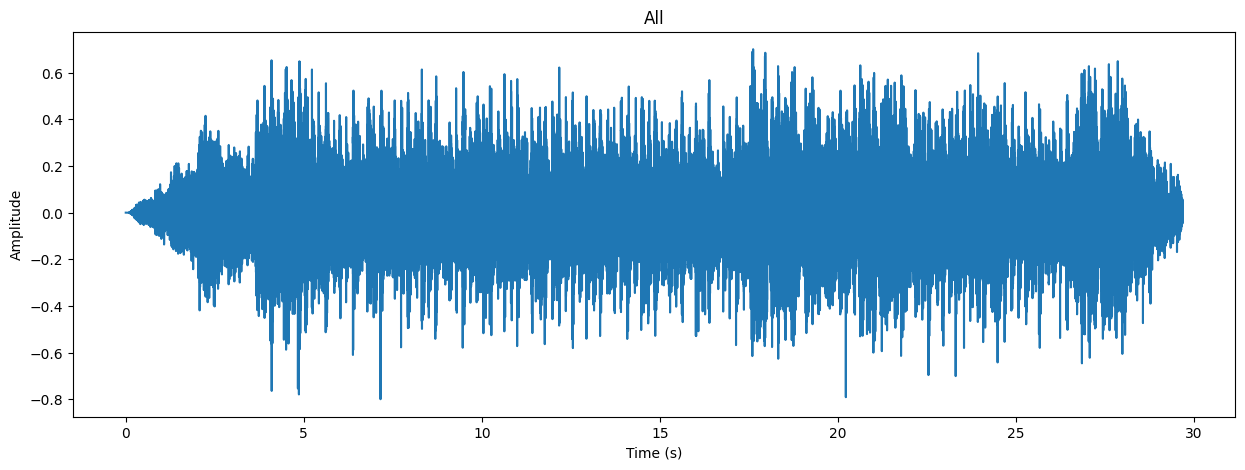

In [206]:
fname = data_path['Path'].iloc[268]
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0, len(data)) / sampling_rate, data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('All')
plt.show()

Audio(fname)

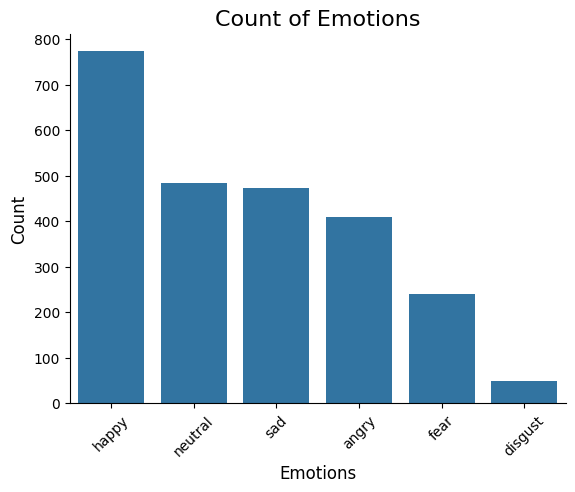

In [207]:
plt.title('Count of Emotions', size=16)
sns.barplot(x=data_path['Emotions'].value_counts().index, y=data_path['Emotions'].value_counts())
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [208]:
def noise(data, noise_rate=0.015): 
    noise_amp = noise_rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size = data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)
    
def shift(data):
    shift_range = int(np.random.uniform(low =- 5, high = 5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sr=sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [209]:
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [210]:
fname = file_path[0]
data, sampling_rate = librosa.load(fname, duration=8, offset=0.6)
print("ZCR: ", zcr(data).shape)
print("RMS :", rmse(data).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (345,)
RMS : (345,)
MFCC:  (6900,)


In [211]:
def extract_features(data, sr, frame_length = 2048, hop_length = 512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [212]:
fname = file_path[0]
data, sampling_rate = librosa.load(fname, duration=8, offset=0.6)
extract_features(data, sampling_rate)

array([ 0.06884766,  0.15234375,  0.19335938, ..., -2.63011575,
        3.82456613,  3.21916509])

In [213]:
def get_features(path):
    data, sampling_rate = librosa.load(path, duration = 5, offset = 3.5)
    
    res1 = extract_features(data,sampling_rate)
    result = np.array(res1)
    
    noise_data = noise(data)
    res2 = extract_features(noise_data, sampling_rate)
    result = np.vstack((result, res2)) 
    
    data_pitch = pitch(data, sampling_rate)
    res3 = extract_features(data_pitch, sampling_rate)
    result = np.vstack((result, res3)) 
    
    data_noise_pitch = noise(data_pitch)
    res4 = extract_features(data_noise_pitch, sampling_rate)
    result = np.vstack((result, res4)) 
    
    return result

In [214]:
X, Y = [], []
i = 0

for path, emotion in zip(data_path.Path, data_path.Emotions):
    i = i+1
    feature = get_features(path)
    print(i)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [215]:
len(X), len(Y), data_path.Path.shape

(9716, 9716, (2429,))

In [216]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features_music_emotion.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,4743,4744,4745,4746,4747,4748,4749,4750,4751,labels
0,0.105957,0.157227,0.204590,0.206543,0.205078,0.210449,0.209961,0.206543,0.176758,0.149902,...,18.901194,-28.014303,-5.700936,-2.879990,-3.290543,-4.012368,9.917994,-13.716498,5.061407,happy
1,0.104004,0.154297,0.201660,0.204590,0.204102,0.210449,0.208984,0.205566,0.174805,0.147949,...,15.873794,-25.443708,-8.391157,-0.517941,-5.251043,-2.103336,8.193607,-12.173040,3.565614,happy
2,0.100098,0.137207,0.201172,0.214355,0.218262,0.232422,0.213379,0.193848,0.171875,0.145508,...,17.084635,-23.895691,13.073873,-1.165637,-8.015844,-1.109802,9.630203,-12.377458,15.395540,happy
3,0.098145,0.134277,0.200195,0.215332,0.225098,0.241211,0.219238,0.197754,0.172852,0.146484,...,8.357458,-15.759944,5.644456,5.991080,-14.114851,4.097211,3.734971,-6.648627,9.392720,happy
4,0.105957,0.157227,0.204590,0.206543,0.205078,0.210449,0.209961,0.206543,0.176758,0.149902,...,18.901194,-28.014303,-5.700936,-2.879990,-3.290543,-4.012368,9.917994,-13.716498,5.061407,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9711,0.018555,0.027344,0.033203,0.052734,0.087891,0.117676,0.143066,0.145508,0.126953,0.120117,...,-2.486103,1.089663,-7.327482,3.819743,10.057867,-2.539855,-5.678596,0.804878,8.837689,sad
9712,0.020508,0.028320,0.043457,0.051758,0.059570,0.067871,0.057617,0.053223,0.051758,0.054688,...,0.588031,6.207839,-12.424069,-19.033051,-7.825285,6.354685,5.781385,2.509068,-8.318398,sad
9713,0.033203,0.045898,0.066895,0.074219,0.083984,0.088379,0.072266,0.062012,0.055664,0.058594,...,-0.200723,6.788590,-11.920498,-19.304420,-7.371991,5.284469,6.822681,2.088239,-7.447618,sad
9714,0.020508,0.032715,0.052734,0.059570,0.065430,0.061035,0.053711,0.055176,0.059570,0.070801,...,4.688559,4.639873,-9.653982,-17.865780,0.551422,6.736993,5.578907,-5.558652,-3.762739,sad


In [217]:
Features = pd.read_csv('features_music_emotion.csv')
print(Features.shape)

(9716, 4753)


In [218]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
4748      False
4749      False
4750      False
4751      False
labels    False
Length: 4753, dtype: bool


(9716, 4753)

In [219]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [220]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
       dtype=object)]

In [221]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8258, 4752), (8258, 6), (1458, 4752), (1458, 6))

In [222]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((8258, 4752),
 (1093, 4752),
 (365, 4752),
 (8258, 4752),
 (1093, 4752),
 (365, 4752))

In [223]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8258, 4752), (8258, 6), (1093, 4752), (1093, 6))

In [224]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8258, 4752, 1), (8258, 6), (1093, 4752, 1), (1093, 6))

In [225]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

In [229]:
model=Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 4752, 256)         1536      
                                                                 
 batch_normalization_40 (Ba  (None, 4752, 256)         1024      
 tchNormalization)                                               
                                                                 
 max_pooling1d_32 (MaxPooli  (None, 2376, 256)         0         
 ng1D)                                                           
                                                                 
 conv1d_33 (Conv1D)          (None, 2376, 256)         327936    
                                                                 
 batch_normalization_41 (Ba  (None, 2376, 256)         1024      
 tchNormalization)                                               
                                                      

In [230]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks=[learning_rate_reduction]

In [231]:
history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
259/259 [==============================] - 412s 2s/step - loss: 1.7644 - accuracy: 0.3273 - val_loss: 2.0136 - val_accuracy: 0.3260 - lr: 0.0010
Epoch 2/100
259/259 [==============================] - 449s 2s/step - loss: 1.4359 - accuracy: 0.4330 - val_loss: 1.4705 - val_accuracy: 0.3342 - lr: 0.0010
Epoch 3/100
259/259 [==============================] - 480s 2s/step - loss: 1.3071 - accuracy: 0.4843 - val_loss: 1.2743 - val_accuracy: 0.5178 - lr: 0.0010
Epoch 4/100
259/259 [==============================] - 482s 2s/step - loss: 1.1561 - accuracy: 0.5482 - val_loss: 1.1085 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 5/100
259/259 [==============================] - 487s 2s/step - loss: 1.0153 - accuracy: 0.6130 - val_loss: 1.0491 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 6/100
259/259 [==============================] - 487s 2s/step - loss: 0.9128 - accuracy: 0.6601 - val_loss: 0.9470 - val_accuracy: 0.6411 - lr: 0.0010
Epoch 7/100
259/259 [==============================] - 483

In [233]:
from keras.models import load_model
model.save('model_music.h5')

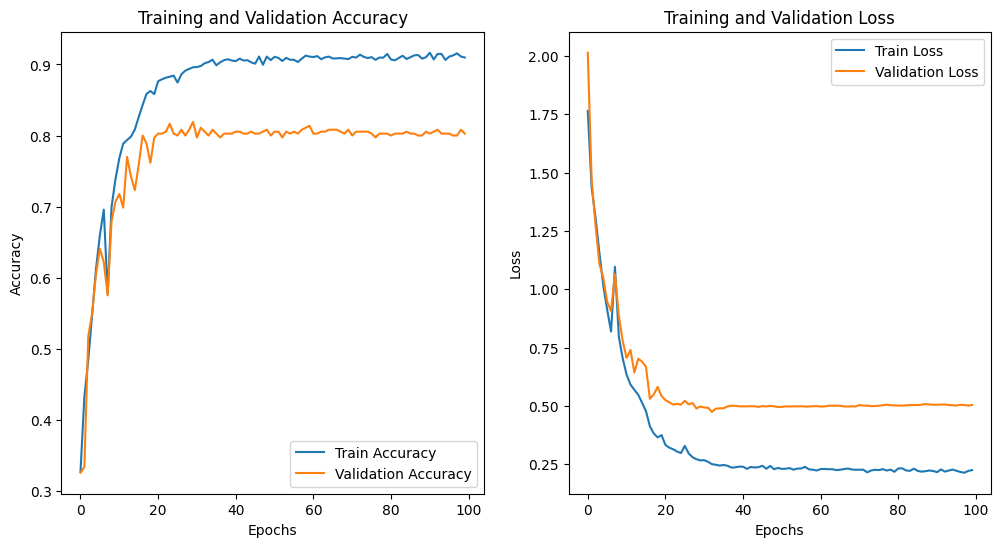

In [234]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [235]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

In [236]:
print("test_accuracy:", round(test_accuracy,4))
print("test_loss:", round(test_loss,4))

test_accuracy: 0.8362
test_loss: 0.4592


In [237]:
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test) 

35/35 [==============================] - 9s 243ms/step


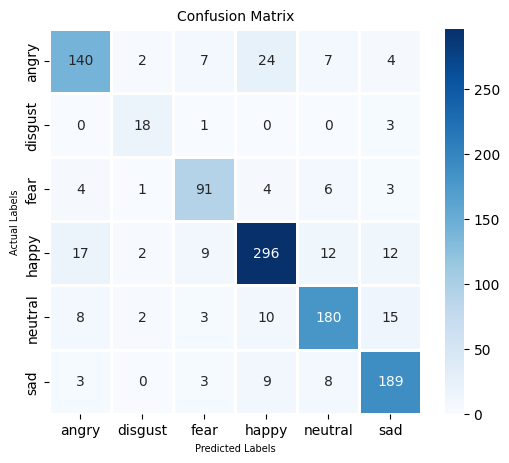

In [238]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 5))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=10)
plt.xlabel('Predicted Labels', size=7)
plt.ylabel('Actual Labels', size=7)
plt.show()

In [239]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.76      0.79       184
     disgust       0.72      0.82      0.77        22
        fear       0.80      0.83      0.82       109
       happy       0.86      0.85      0.86       348
     neutral       0.85      0.83      0.84       218
         sad       0.84      0.89      0.86       212

    accuracy                           0.84      1093
   macro avg       0.81      0.83      0.82      1093
weighted avg       0.84      0.84      0.84      1093



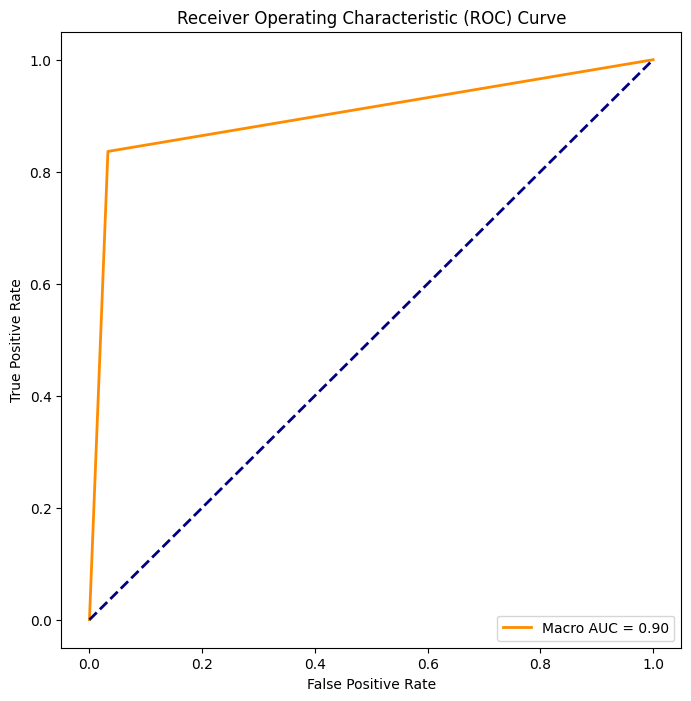

In [301]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_bin = lb.transform(y_pred)

roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Macro AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [240]:
import pickle

with open('history_music.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [260]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

,Predicted Labels,Actual Labels
0,neutral,fear
1,happy,happy
2,neutral,neutral
3,neutral,fear
4,happy,happy
5,happy,sad
6,fear,fear
7,neutral,neutral
8,happy,happy
9,neutral,angry


In [316]:
data = {
    'Emotions': ['happy', 'angry', 'neutral', 'sad', 'fear', 'disgust'],
    'Jasno pomarańczowy': [13, 1, 6, 2, 2, 2],
    'Czerwony': [18, 25, 3, 1, 17, 2],
    'Biały': [0, 1, 13, 1, 3, 0],
    'Ciemno pomarańczowy': [10, 2, 4, 3, 5, 4],
    'Granatowy': [8, 0, 7, 38, 13, 2],
    'Ciemno czerwony': [5, 7, 0, 2, 9, 3],
    'Zielony': [51, 0, 14, 4, 2, 0],
    'Czarny': [2, 3, 0, 5, 15, 1],
    'Żółty': [79, 3, 14, 4, 2, 0],
    'Jasno szary': [1, 0, 15, 10, 3, 4],
    'Niebieski': [14, 0, 20, 37, 11, 1],
    'Jasno niebieski': [10, 0, 10, 13, 7, 1],
    'Jasno jasno niebieski': [5, 0, 13, 16, 3, 1],
    'Pomarańczowy': [41, 8, 6, 6, 6, 2],
    'Ciemno szary': [2, 2, 24, 27, 29, 8],
    'Fioletowy': [9, 2, 2, 9, 13, 4],
    'Jasno żółty': [20, 0, 5, 4, 2, 1],
    'Jasno jasno czerwony': [5, 0, 4, 3, 1, 1],
    'Jasno granatowy': [3, 0, 6, 21, 5, 0],
    'Jasno czerwony': [13, 7, 5, 0, 4, 2],
    'Ciemno granatowy': [1, 4, 2, 14, 15, 2],
    'Ciemno żółty': [3, 2, 2, 3, 2, 1],
    'Jasno zielony': [21, 0, 11, 0, 1, 1],
    'Jasno jasno żółty': [5, 0, 8, 3, 2, 1],
    'Jasno fioletowy': [4, 0, 3, 7, 3, 3],
    'Ciemno zielony': [9, 1, 2, 3, 2, 2],
    'Jasno jasno pomarańczowy': [1, 0, 6, 0, 1, 0],
    'Ciemno niebieski': [1, 0, 2, 12, 4, 2],
    'Jasno jasno granatowy': [2, 0, 6, 10, 1, 0],
    'Ciemno fioletowy': [3, 8, 1, 4, 12, 2],
    'Jasno jasno zielony': [6, 0, 3, 4, 3, 1],
    'Jasno jasno fioletowy': [6, 0, 2, 4, 3, 0],
    'Cienno fioletowy': [0, 0, 0, 1, 0, 0]
}

df_col = pd.DataFrame(data)

emotions = df_col['Emotions']
colors = df_col.columns[1:]
probabilities = {}

for emotion in emotions:
    total_occurrences = df_col[df_col['Emotions'] == emotion][colors].sum().sum()
    probabilities[emotion] = {}
    for color in colors:
        color_occurrences = df_col.loc[df_col['Emotions'] == emotion, color].sum()
        probabilities[emotion][color] = color_occurrences / total_occurrences

probabilities_df = pd.DataFrame(probabilities).T
probabilities_df

,Jasno pomarańczowy,Czerwony,Biały,Ciemno pomarańczowy,Granatowy,Ciemno czerwony,Zielony,Czarny,Żółty,Jasno szary,...,Jasno jasno żółty,Jasno fioletowy,Ciemno zielony,Jasno jasno pomarańczowy,Ciemno niebieski,Jasno jasno granatowy,Ciemno fioletowy,Jasno jasno zielony,Jasno jasno fioletowy,Cienno fioletowy
happy,0.035040,0.048518,0.000000,0.026954,0.021563,0.013477,0.137466,0.005391,0.212938,0.002695,...,0.013477,0.010782,0.024259,0.002695,0.002695,0.005391,0.008086,0.016173,0.016173,0.00000
angry,0.013158,0.328947,0.013158,0.026316,0.000000,0.092105,0.000000,0.039474,0.039474,0.000000,...,0.000000,0.000000,0.013158,0.000000,0.000000,0.000000,0.105263,0.000000,0.000000,0.00000
neutral,0.027397,0.013699,0.059361,0.018265,0.031963,0.000000,0.063927,0.000000,0.063927,0.068493,...,0.036530,0.013699,0.009132,0.027397,0.009132,0.027397,0.004566,0.013699,0.009132,0.00000
sad,0.007380,0.003690,0.003690,0.011070,0.140221,0.007380,0.014760,0.018450,0.014760,0.036900,...,0.011070,0.025830,0.011070,0.000000,0.044280,0.036900,0.014760,0.014760,0.014760,0.00369
fear,0.009950,0.084577,0.014925,0.024876,0.064677,0.044776,0.009950,0.074627,0.009950,0.014925,...,0.009950,0.014925,0.009950,0.004975,0.019900,0.004975,0.059701,0.014925,0.014925,0.00000
disgust,0.037037,0.037037,0.000000,0.074074,0.037037,0.055556,0.000000,0.018519,0.000000,0.074074,...,0.018519,0.055556,0.037037,0.000000,0.037037,0.000000,0.037037,0.018519,0.000000,0.00000


In [318]:
df_head = df.head(20)
df_head

,Predicted Labels,Actual Labels
0,neutral,fear
1,happy,happy
2,neutral,neutral
3,neutral,fear
4,happy,happy
5,happy,sad
6,fear,fear
7,neutral,neutral
8,happy,happy
9,neutral,angry


In [320]:
probabilities_df_normalized = probabilities_df.div(probabilities_df.sum(axis=1), axis=0)

def sample_color(emotion):
    probabilities = probabilities_df_normalized.loc[emotion]
    return np.random.choice(probabilities.index, p=probabilities)


df_head['Colors'] = df_head['Predicted Labels'].apply(sample_color)

save_df = df_head

In [330]:
from collections import Counter

emotion_to_sample = 'happy'
num_samples = 1000

results = []

for _ in range(num_samples):
    sampled_color = sample_color(emotion_to_sample)
    results.append(sampled_color)

print(f"Emotion: {emotion_to_sample}")
print(f"Results after {num_samples} samples: {results}")

color_counts = Counter(results)
print("Color counts:")
for color, count in color_counts.items():
    print(f"{color}: {count} times")

Emotion: happy
Results after 1000 samples: ['Jasno żółty', 'Jasno zielony', 'Jasno jasno fioletowy', 'Żółty', 'Zielony', 'Zielony', 'Żółty', 'Jasno żółty', 'Jasno jasno żółty', 'Jasno czerwony', 'Jasno jasno czerwony', 'Jasno niebieski', 'Jasno niebieski', 'Jasno niebieski', 'Żółty', 'Żółty', 'Żółty', 'Zielony', 'Żółty', 'Zielony', 'Zielony', 'Żółty', 'Jasno zielony', 'Jasno jasno czerwony', 'Niebieski', 'Pomarańczowy', 'Żółty', 'Fioletowy', 'Ciemno zielony', 'Żółty', 'Zielony', 'Żółty', 'Jasno żółty', 'Pomarańczowy', 'Zielony', 'Żółty', 'Pomarańczowy', 'Żółty', 'Jasno żółty', 'Jasno granatowy', 'Żółty', 'Jasno zielony', 'Zielony', 'Żółty', 'Żółty', 'Żółty', 'Żółty', 'Żółty', 'Zielony', 'Żółty', 'Zielony', 'Niebieski', 'Czerwony', 'Zielony', 'Jasno czerwony', 'Żółty', 'Zielony', 'Zielony', 'Jasno żółty', 'Jasno jasno zielony', 'Żółty', 'Jasno zielony', 'Zielony', 'Żółty', 'Żółty', 'Fioletowy', 'Fioletowy', 'Jasno jasno żółty', 'Zielony', 'Fioletowy', 'Zielony', 'Ciemno czerwony', 'Jasn

In [333]:
save_df

,Predicted Labels,Actual Labels,Colors,Colors_RGB
0,neutral,fear,Jasno jasno niebieski,"rgb(214, 244, 246)"
1,happy,happy,Niebieski,"rgb(46, 186, 210)"
2,neutral,neutral,Granatowy,"rgb(46, 91, 210)"
3,neutral,fear,Ciemno szary,"rgb(118, 118, 118)"
4,happy,happy,Jasno jasno czerwony,"rgb(250, 101, 113)"
5,happy,sad,Jasno zielony,"rgb(161, 217, 121)"
6,fear,fear,Niebieski,"rgb(46, 186, 210)"
7,neutral,neutral,Ciemno szary,"rgb(118, 118, 118)"
8,happy,happy,Jasno jasno żółty,"rgb(255, 246, 203)"
9,neutral,angry,Jasno jasno pomarańczowy,"rgb(255, 230, 202)"


In [334]:
color_rgb_mapping = {
    'Biały': (247, 247, 247),
    'Jasno żółty': (255, 233, 123),
    'Ciemno szary': (118, 118, 118),
    'Ciemno granatowy': (28, 55, 126),
    'Jasno granatowy': (130, 157, 228),
    'Czarny': (0, 0, 0),
    'Jasno szary': (183, 183, 183),
    'Jasno niebieski': (130, 213, 228),
    'Ciemno pomarańczowy': (150, 81, 1),
    'Jasno jasno żółty': (255, 246, 203),
    'Czerwony': (238, 0, 18),
    'Żółty': (253, 212, 1),
    'Jasno pomarańczowy': (254, 183, 101),
    'Niebieski': (46, 186, 210),
    'Ciemno czerwony': (136, 0, 10),
    'Jasno fioletowy': (206, 129, 230),
    'Jasno jasno niebieski': (214, 244, 246),
    'Granatowy': (46, 91, 210),
    'Jasno jasno czerwony': (250, 101, 113),
    'Jasno zielony': (161, 217, 121),
    'Jasno jasno pomarańczowy': (255, 230, 202),
    'Ciemno fioletowy': (82, 26, 99),
    'Pomarańczowy': (251, 136, 2),
    'Fioletowy': (149, 47, 180),
    'Jasno niebieski': (130, 213, 228)
    
    
    
    
}

df_head['Colors_RGB'] = df_head['Colors'].apply(lambda color: color_rgb_mapping[color])

df_head['Colors_RGB'] = df_head['Colors_RGB'].apply(lambda rgb: f'rgb{rgb}')

styled_df_rgb = df_head.style.applymap(color_cells, subset=['Colors_RGB'])
styled_df_rgb

,Predicted Labels,Actual Labels,Colors,Colors_RGB
0,neutral,fear,Jasno jasno niebieski,"rgb(214, 244, 246)"
1,happy,happy,Niebieski,"rgb(46, 186, 210)"
2,neutral,neutral,Granatowy,"rgb(46, 91, 210)"
3,neutral,fear,Ciemno szary,"rgb(118, 118, 118)"
4,happy,happy,Jasno jasno czerwony,"rgb(250, 101, 113)"
5,happy,sad,Jasno zielony,"rgb(161, 217, 121)"
6,fear,fear,Niebieski,"rgb(46, 186, 210)"
7,neutral,neutral,Ciemno szary,"rgb(118, 118, 118)"
8,happy,happy,Jasno jasno żółty,"rgb(255, 246, 203)"
9,neutral,angry,Jasno jasno pomarańczowy,"rgb(255, 230, 202)"
